# Bitcoin Price Prediction using Deep Learning

## Introduction

This notebook demonstrates a project focused on forecasting the price of Bitcoin using time series forecasting techniques, machine learning and specifically deep learning models implemented in TensorFlow. The goal is to leverage historical Bitcoin price data to create a model that can provide accurate future price predictions.

## GPU checking

In [3]:
# Check for GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get the data

In [4]:
# Download the Bitcoin historical data from my GitHub repository
!wget https://raw.githubusercontent.com/IsraelAzoulay/BTC-Price-Predictor/main/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-05-16 20:26:21--  https://raw.githubusercontent.com/IsraelAzoulay/BTC-Price-Predictor/main/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2024-05-16 20:26:22 (7.05 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Inspect the data

In [5]:
import pandas as pd
# Parse the dates and set the date column to be the index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [7]:
# Checking the number of samples in the dataset
len(df)

2787

## Preprocess the data

In [8]:
# Keeping only the closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


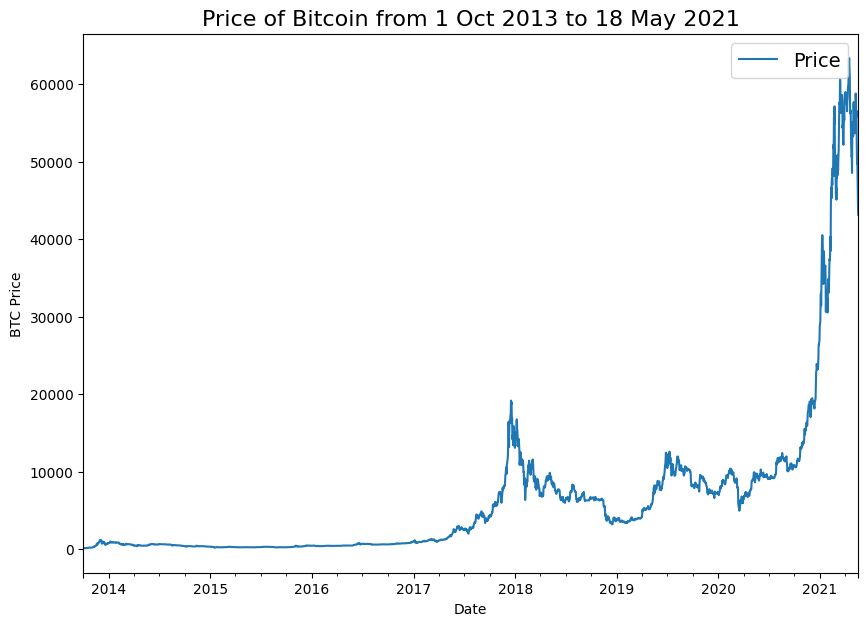

In [9]:
# Let's visualise the price against the date
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

For practice purposes, since the time series data is in CSV format, let's use the Python's in-built csv module to import the data instead of Pandas:

In [10]:
import csv
from datetime import datetime

# Create an empty list for the timesteps
timesteps = []
# Create an empty list for the price
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# Display the first 5 of each
timesteps[:5], btc_price[:5]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0)],
 [123.65499, 125.455, 108.58483, 118.67466, 121.33866])

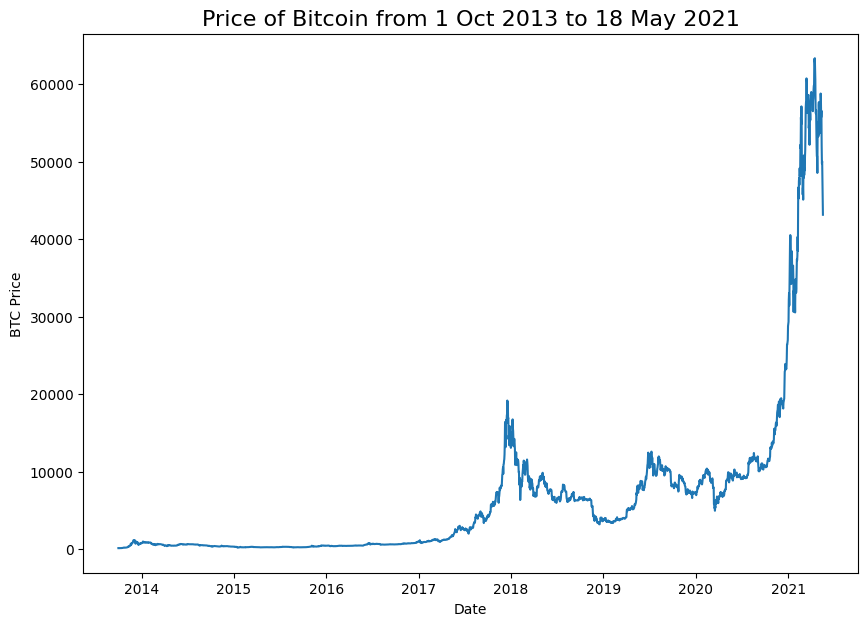

In [11]:
# Let's visualize the price against the date
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

Let's continue working with the 'bitcoin_prices' Pandas dataframe we have created earlier:

## Create train/test sets for **time series**

In [12]:
# Turning the DataFrame index and column into NumPy arrays
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [13]:
# Create train/test splits of 80% train set and 20% test set
split_size = int(0.8 * len(prices))
# Create train data splits, everything before the split
X_train, y_train = timesteps[:split_size], prices[:split_size]
# Create test data splits, everything after the split
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

In [14]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  The function plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")

  if label:
    plt.legend(fontsize=14)

  plt.grid(True)

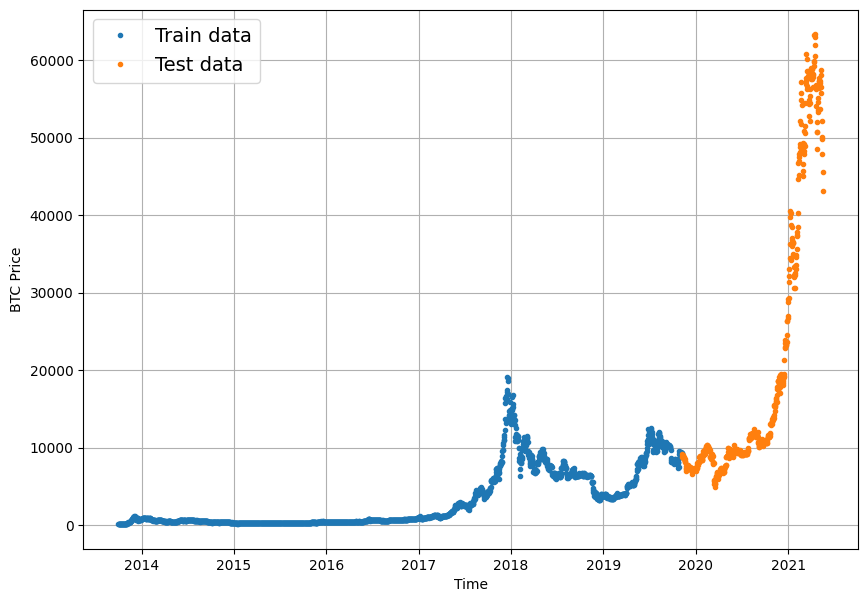

In [15]:
# Plot the train/test splits
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Create, Evaluate and Predict with ‘model_0’ - Naive Forecast (baseline, ML model)

In [16]:
# Create a Naive forecast. It equals all the values except of the last one.
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

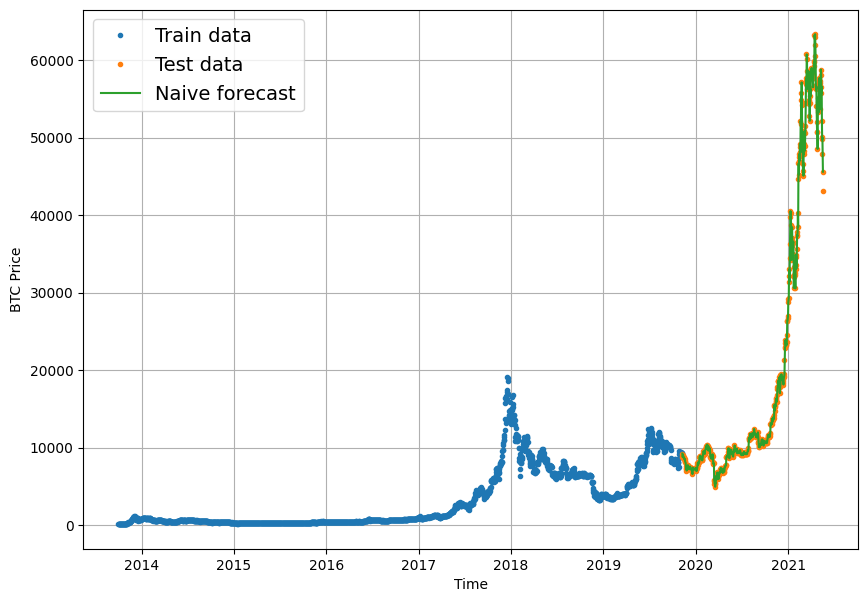

In [17]:
# Plot the Naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

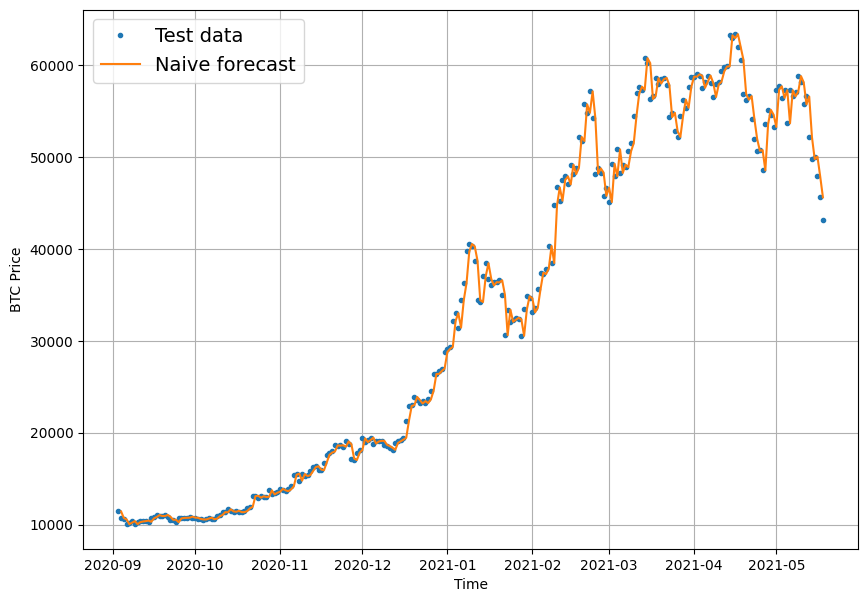

In [18]:
# Plot the Naive forecast with a zoom-in
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [19]:
import tensorflow as tf

def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (mean aboslute scaled error) metric implemetation, assuming no seasonality of data.
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  # in our case the seasonality is of one day, thus shifting of one day
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

In [20]:
# Creating a function with all the different evaluation metrics in it
def evaluate_preds(y_true, y_pred):
  # Making sure they are of float32 for better metric calculations
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [21]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [22]:
# Getting the average price in the test set for measuring purposes
tf.reduce_mean(y_test).numpy()

20056.632963737226

## Create, Evaluate and Predict with ‘model_1’ - Dense layers model with ‘window’ = 7, ‘horizon’ = 1 (DL model)

In [23]:
# Windowing the dataset - using a week worth of timesteps, to predict the horizon which is 1 step at a time
HORIZON = 1
WINDOW_SIZE = 7

In [24]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.
  """
  return x[:, :-horizon], x[:, -horizon:]

In [25]:
# Let's test 'get_labelled_windows' function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [26]:
import numpy as np

def make_windows(x, window_size=7, horizon=1):
  """
  Views NumPy arrays as windows of window_size.
  """
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]

  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [27]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [28]:
print("First 5 windows and labels:")
for i in range(5):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")



First 5 windows and labels:
Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]
Window: [118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116] -> Label: [125.27966]
Window: [121.33866 120.65533 121.795   123.033   124.049   125.96116 125.27966] -> Label: [125.9275]


In [29]:
print("Last 5 windows and labels:")
for i in range(5):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Last 5 windows and labels:
Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]
Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]


In [30]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  The function creates train/test splits of 80% train set and 20% test set
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [31]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [32]:
train_windows[:10], train_labels[:10]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966],
        [120.65533, 121.795  , 123.033  , 124.049  , 125.96116, 125.27966,
         125.9275 ],
        [121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333],
        [123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199],
        [124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333],
        [125.96116, 125.27966, 125.9275 , 126.38333, 135.24199, 133.20333,
         142.76333]]),
 array([[123.033  ],
        [124.049 

In [33]:
# Checking if they are identical
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [34]:
import os

# Create a function that implements a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Setting the random seed for getting reproducible results
tf.random.set_seed(42)

# Build, compile and fit 'model_1'
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 79ms/step - loss: 2080.6621 - mae: 2080.6621 - val_loss: 945.4496 - val_mae: 945.4496
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 381.0559 - mae: 381.0559 - val_loss: 1990.6794 - val_mae: 1990.6794
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 236.1411 - mae: 236.1411 - val_loss: 1069.2223 - val_mae: 1069.2223
Epoch 4/100
18/18 [==============================] - 1s 36ms/step - loss: 180.6265 - mae: 180.6265 - val_loss: 928.0976 - val_mae: 928.0976
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 168.5224 - mae: 168.5224 - val_loss: 947.5701 - val_mae: 947.5701
Epoch 6/100
18/18 [==============================] - 0s 29ms/step - loss: 161.6070 - mae: 161.6070 - val_loss: 876.4165 - val_mae: 876.4165
Epoch 7/100
18/18 [==============================] - 1s 31ms/step - loss: 156.1004 - mae: 156.1004 - val_loss: 871.7676 - val_mae: 871.7676
Epoch 8/100
18/18

In [36]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 663.9399 - mae: 663.9399


[663.9398803710938, 663.9398803710938]

In [37]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 567.8935 - mae: 567.8935


[567.8934936523438, 567.8934936523438]

In [38]:
def make_preds(model, input_data):
  """
  The function use the model to make predictions on an 'input_data'.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data, the same kind of data the model was trained on

  Returns model predictions on the 'input_data'.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [39]:
# Let's make predictions on the test set with 'model_1'
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8831.194, 8743.42 , 9014.361, 8767.215, 8716.544, 8750.247,
        8637.27 , 8523.891, 8435.75 , 8510.713], dtype=float32)>)

In [40]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 567.8934,
 'mse': 1165096.9,
 'rmse': 1079.3965,
 'mape': 2.5436032,
 'mase': 0.9976314}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

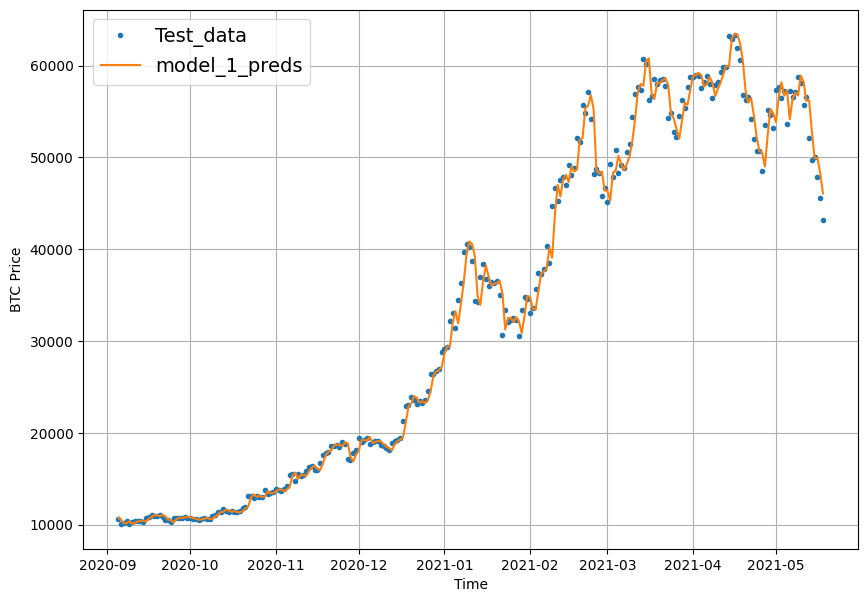

In [42]:
# Plot the 'model_1_preds' against the test data
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Create, Evaluate and Predict with ‘model_2’ - Dense layers model with ‘window’ = 30, ‘horizon’ = 1 (DL model)

In [43]:
# Using a 30 days of timesteps, to predict the horizon which is 1 step at a time
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# Creating windowed data with the modified horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Creating train/test windoes with the new windowed data
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
# Setting the random seed for getting reproducible results
tf.random.set_seed(42)

# Build, compile and fit 'model_2'
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 625.3403


625.34033203125

In [48]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 621.6407


621.6407470703125

In [49]:
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [50]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 621.64087,
 'mse': 1323835.4,
 'rmse': 1150.5804,
 'mape': 2.8103075,
 'mase': 1.0866343}

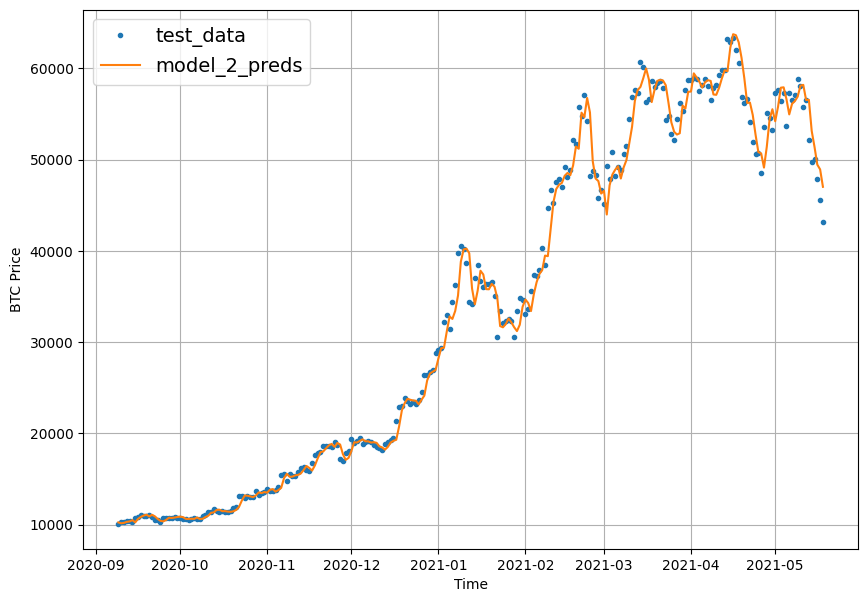

In [51]:
# Let's visualise
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Create, Evaluate and Predict with ‘model_3’ - Dense layers model with ‘window’ = 30, ‘horizon’ = 7 (DL model)

In [52]:
# Updating the horizon and window size, and windowing the data
HORIZON = 7
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [53]:
# Creating new train/test set based with the new windowed data
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [54]:
# Setting the random seed for getting reproducible results
tf.random.set_seed(42)

# Build, compile and fit 'model_3'
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1321.0225


1321.0224609375

In [56]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1220.9640


1220.9639892578125

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9468.683 , 9347.59  , 9490.282 , 9568.202 , 9376.583 , 9516.672 ,
        9494.457 ],
       [9229.984 , 9053.419 , 9105.369 , 9256.384 , 8938.24  , 9146.225 ,
        9333.203 ],
       [8886.504 , 9073.082 , 8883.471 , 9024.241 , 8857.679 , 8999.596 ,
        9189.105 ],
       [8772.655 , 9144.022 , 8936.326 , 9225.247 , 9220.806 , 9181.5   ,
        9296.264 ],
       [8839.3125, 8927.014 , 8863.672 , 9086.476 , 9003.963 , 9112.221 ,
        8901.97  ]], dtype=float32)>

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  672.852   ,   408.50992 ,   339.00488 ,   484.37973 ,
          407.74176 ,   418.57037 ,   469.15765 ,   496.2103  ,
          562.2494  ,   546.8763  ,   736.3539  ,   783.5898  ,
          878.0521  ,   935.1883  ,   611.23596 ,   269.91016 ,
          227.84026 ,   288.91156 ,   233.85303 ,   249.65715 ,
          151.49191 ,   193.28557 ,   314.87967 ,   377.30908 ,
          171.16281 ,   144.024   ,   112.30999 ,   136.0851  ,
          163.32191 ,   168.50209 ,   288.7653  ,   390.03433 ,
          345.6213  ,   361.34564 ,   271.83496 ,   316.85855 ,
          312.52554 ,   223.76375 ,   236.04283 ,   257.8974  ,
          530.58356 ,    76.453964,    64.64997 ,    72.77267 ,
           94.18659 ,   107.79018 ,   107.50635 ,   135.66385 ,
          111.26256 ,    92.570595,   104.78844 ,   148.23967 ,
          172.85094 ,   147.46094 ,   266.22232 ,   382.1653  ,
          501.51666 ,   516.2495  ,   490.58405 ,   579.0016  ,
          363.1716  ,   168.35994

The outputs for 'model_3_results' are multi-dimensional since that in this experiment the predictions are being evaluated accross 7 predictions at a time (because 'HORIZON=7').
Hence, modify the 'evaluate_preds()' function and make sure it can successfully work with multi-dimensional data:

In [59]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Making sure the function can work work with multi-dimensional
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [60]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1220.964,
 'mse': 5253782.5,
 'rmse': 1404.6177,
 'mape': 5.4848566,
 'mase': 2.172637}

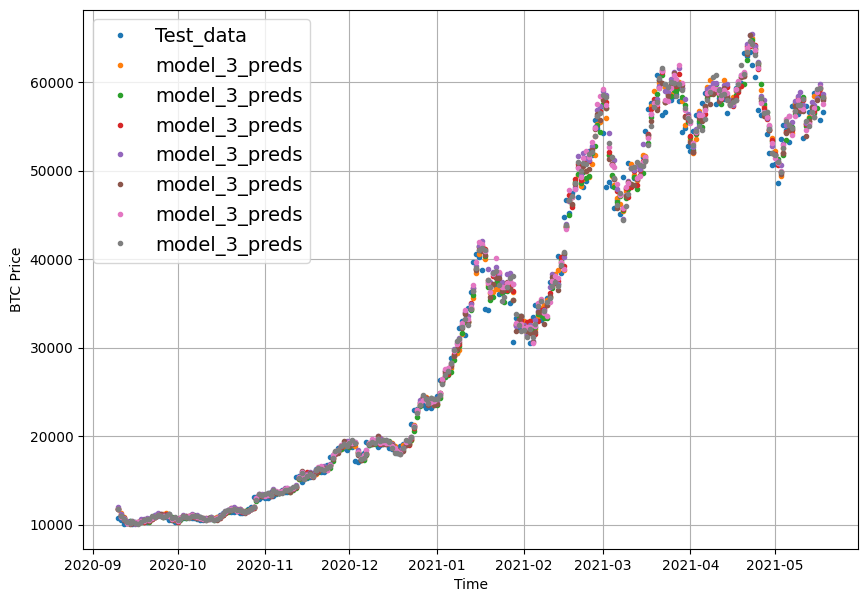

In [61]:
# Let's visualize
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

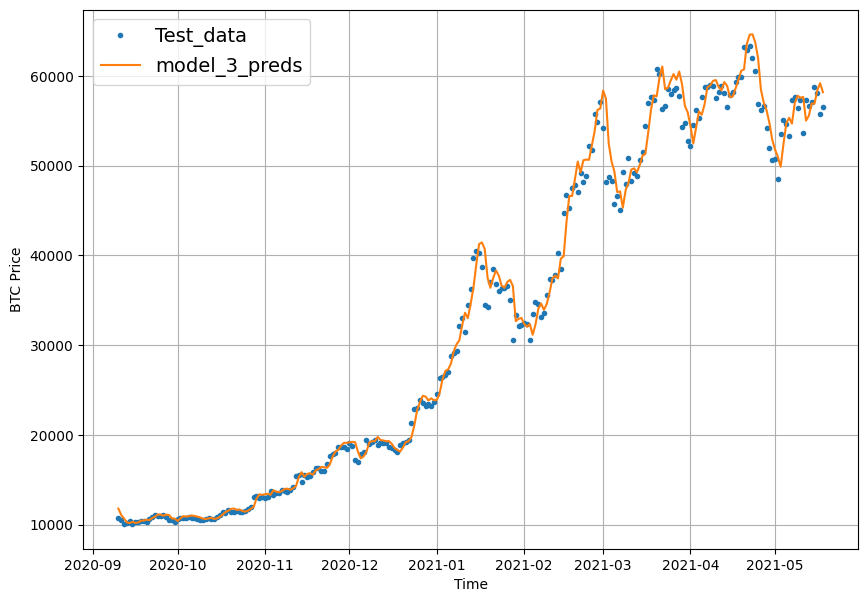

In [62]:
# Let's aggregate the model's predictions for a better plotting
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

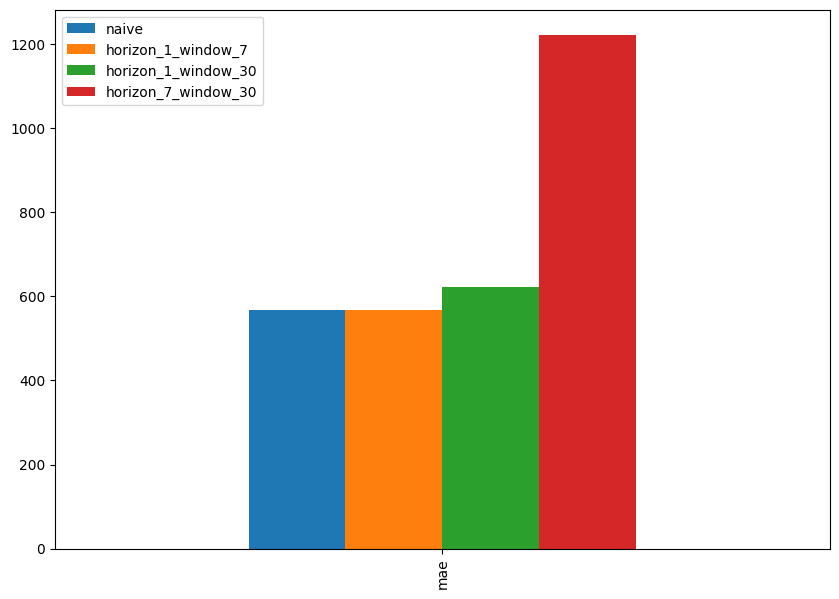

In [63]:
# Comparing the models built so far with a Pandas dataframe
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Create, Evaluate and Predict with ‘model_4’ - Conv1D (DL model)

In [64]:
# Updating the horizon and window size, and windowing the data
HORIZON = 1
WINDOW_SIZE = 7

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [65]:
# Creating new train/test set based with the new windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [66]:
# Creating new train/test set based with the new windowed data
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [67]:
# Finding out what's a sample shapes
train_windows[0].shape

(7,)

Since the data only has 'timesteps' ('WINDOW_SIZE') dimension of 7, and the Conv1D layer in TensorFlow requires '(batch_size, timesteps, input_dim)' as an input, let's modify the shape of all the 'train_windows' to include the 'input_dim' dimension as well by using the 'tf.expand_dims' method in a TensorFlow Lambda layer as follows:

Note:
The 'batch_size' is already set to 32 by default, hence we don't have to take care of it.

In [68]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [69]:
# Setting the random seed for getting reproducible results
tf.random.set_seed(42)

# Build, compile and fit 'model_4'
model_4 = tf.keras.Sequential([
  # Include the Lamda layer
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [70]:
# Get the summary of the model
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 570.6254


570.6254272460938

In [72]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8901.191, 8796.89 , 9013.003, 8793.386, 8755.021, 8755.429,
       8691.083, 8534.759, 8481.355, 8525.697], dtype=float32)>

In [73]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.6254,
 'mse': 1182250.5,
 'rmse': 1087.3135,
 'mape': 2.548298,
 'mase': 1.0024308}

## Create, Evaluate and Predict with ‘model_5’ - RNN LSTM (DL model)

In [74]:
# Setting the random seed for getting reproducible results
tf.random.set_seed(42)

# Build, compile and fit 'model_5' with the Functional API
# Create the inputs
inputs = layers.Input(shape=(WINDOW_SIZE))
# Expand the input dimension so that they could work with LSTM
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
# Output layer
output = layers.Dense(HORIZON)(x)
# Combining the inputs and outputs
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [75]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 579.4185


579.41845703125

In [76]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8941.9375, 8816.86  , 8990.083 , 8822.127 , 8771.602 , 8748.373 ,
       8703.427 , 8573.896 , 8478.992 , 8530.061 ], dtype=float32)>

In [77]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 579.41846,
 'mse': 1217186.1,
 'rmse': 1103.2616,
 'mape': 2.6273587,
 'mase': 1.0178777}

## Create, Evaluate and Predict with ‘model_6’ - Dense layers model with ‘window’ = 7, ‘horizon’ = 1, **multivariate** time series (DL model)

Until now we used **univariate** time series data since we tried to predict the price of Bitcoin by using only the historical price of Bitcoin.
However, let's now encode the block reward size data into our time series data (making our time series data to be **multivariate**), so that we could use the price as well as the block reward size data to try to predict the future price and improve the performance of a model.

Note: The block rewards and dates were taken from cmcmarkets.com.



In [78]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [79]:
# The block reward values
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# The block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [80]:
# Get date indexes for when to add the block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [81]:
# Adding another feature (column) to our dataset named 'block_reward'
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


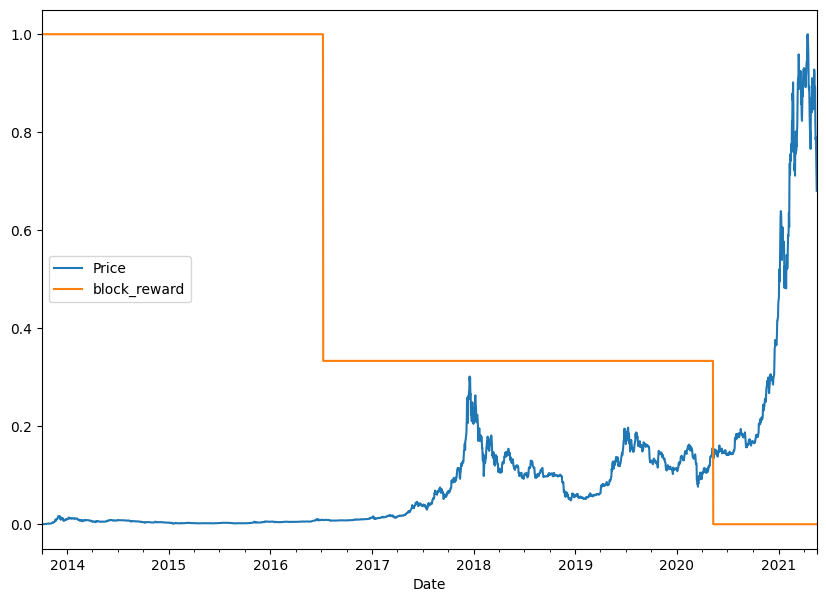

In [82]:
# Let's visualize the block reward/price over time
from sklearn.preprocessing import minmax_scale

# Scaling the values to be between 0 and 1, since they are on different scales
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7));

In [83]:
# Updating the horizon and window size, and windowing the data
HORIZON = 1
WINDOW_SIZE = 7

In [84]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Adding the windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [85]:
# Let's create X & y (labels) and remove the NaN's
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [86]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [87]:
# Create train/test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [88]:
tf.random.set_seed(42)

# Build, compile and fit 'model_6'
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [89]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 566.0220


566.0220336914062

In [90]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8871.684, 8771.136, 9012.437, 8796.718, 8741.315, 8738.281,
       8682.142, 8535.208, 8455.938, 8523.655], dtype=float32)>

In [91]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 566.02203,
 'mse': 1171717.1,
 'rmse': 1082.4589,
 'mape': 2.5572722,
 'mase': 0.99434394}

In [92]:
model_1_results

{'mae': 567.8934,
 'mse': 1165096.9,
 'rmse': 1079.3965,
 'mape': 2.5436032,
 'mase': 0.9976314}

In [93]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Create, Evaluate and Predict with ‘model_7’ - N-BEATS Algorithm (DL model)

For this model let's replicate the generic architecture of the N-BEATS algorithm [available at section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437), and see if it improves a model's performance.


In [94]:
# Creating a NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Create a stack of four fully connected layers in the block
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    # passing the inputs through each one of the hidden layers
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

    return backcast, forecast

In [95]:
# Creating a dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [96]:
# Creating dummy inputs of the same size as 'input_size'
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [97]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# Print the activation outputs of the theta layer
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.20531291  0.5908289   0.21348403  0.44272938  0.25000232 -1.0115709
  1.0063341 ]
Forecast: -0.01760941743850708


In [98]:
# Updating the horizon and window size, and windowing the data
HORIZON = 1
WINDOW_SIZE = 7

In [99]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [100]:
# Adding in the windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [101]:
# Create the features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Create train/test set of 80% train data and 20% test data
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [102]:
# Transform the train arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

# Transform the test arrays into tensor Datasets
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine the features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Display the new train/test sets
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [103]:
# Setting up the values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [104]:
# Create two tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract layer
subtracted = layers.subtract([tensor_1, tensor_2])
# Add layer
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [105]:
%%time

# Setting the random seed for getting reproducible results
tf.random.set_seed(42)

# Build, compile and fit 'model_7'
# Creating the N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# Createing an input to the stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# Createing the backcast and forecast input
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# Createing stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  # Creating the double residual stacking - substact and add
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# Combining the inputs and outputs
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# Including EarlyStopping and ReduceLROnPlateau callbacks in the fitting process of the model
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 377: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 477: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1h 28min 8s, sys: 1min 13s, total: 1h 29min 22s
Wall time: 1h 9min 43s


In [106]:
# Let's evaluate the 'model_7' on the test set
model_7.evaluate(test_dataset)

1/1 [==============================] - 1s 738ms/step - loss: 574.1437 - mae: 574.1437 - mse: 1154628.5000


[574.1436767578125, 574.1436767578125, 1154628.5]

In [107]:
# Let's make some predictions with 'model_7'
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 4s 4s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8908.513 , 8826.6045, 9048.804 , 8829.781 , 8787.568 , 8768.167 ,
       8680.014 , 8573.625 , 8492.045 , 8545.396 ], dtype=float32)>

In [108]:
# Evaluate 'model_7' predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 574.1437,
 'mse': 1154628.5,
 'rmse': 1074.5364,
 'mape': 2.6549022,
 'mase': 1.0086114}

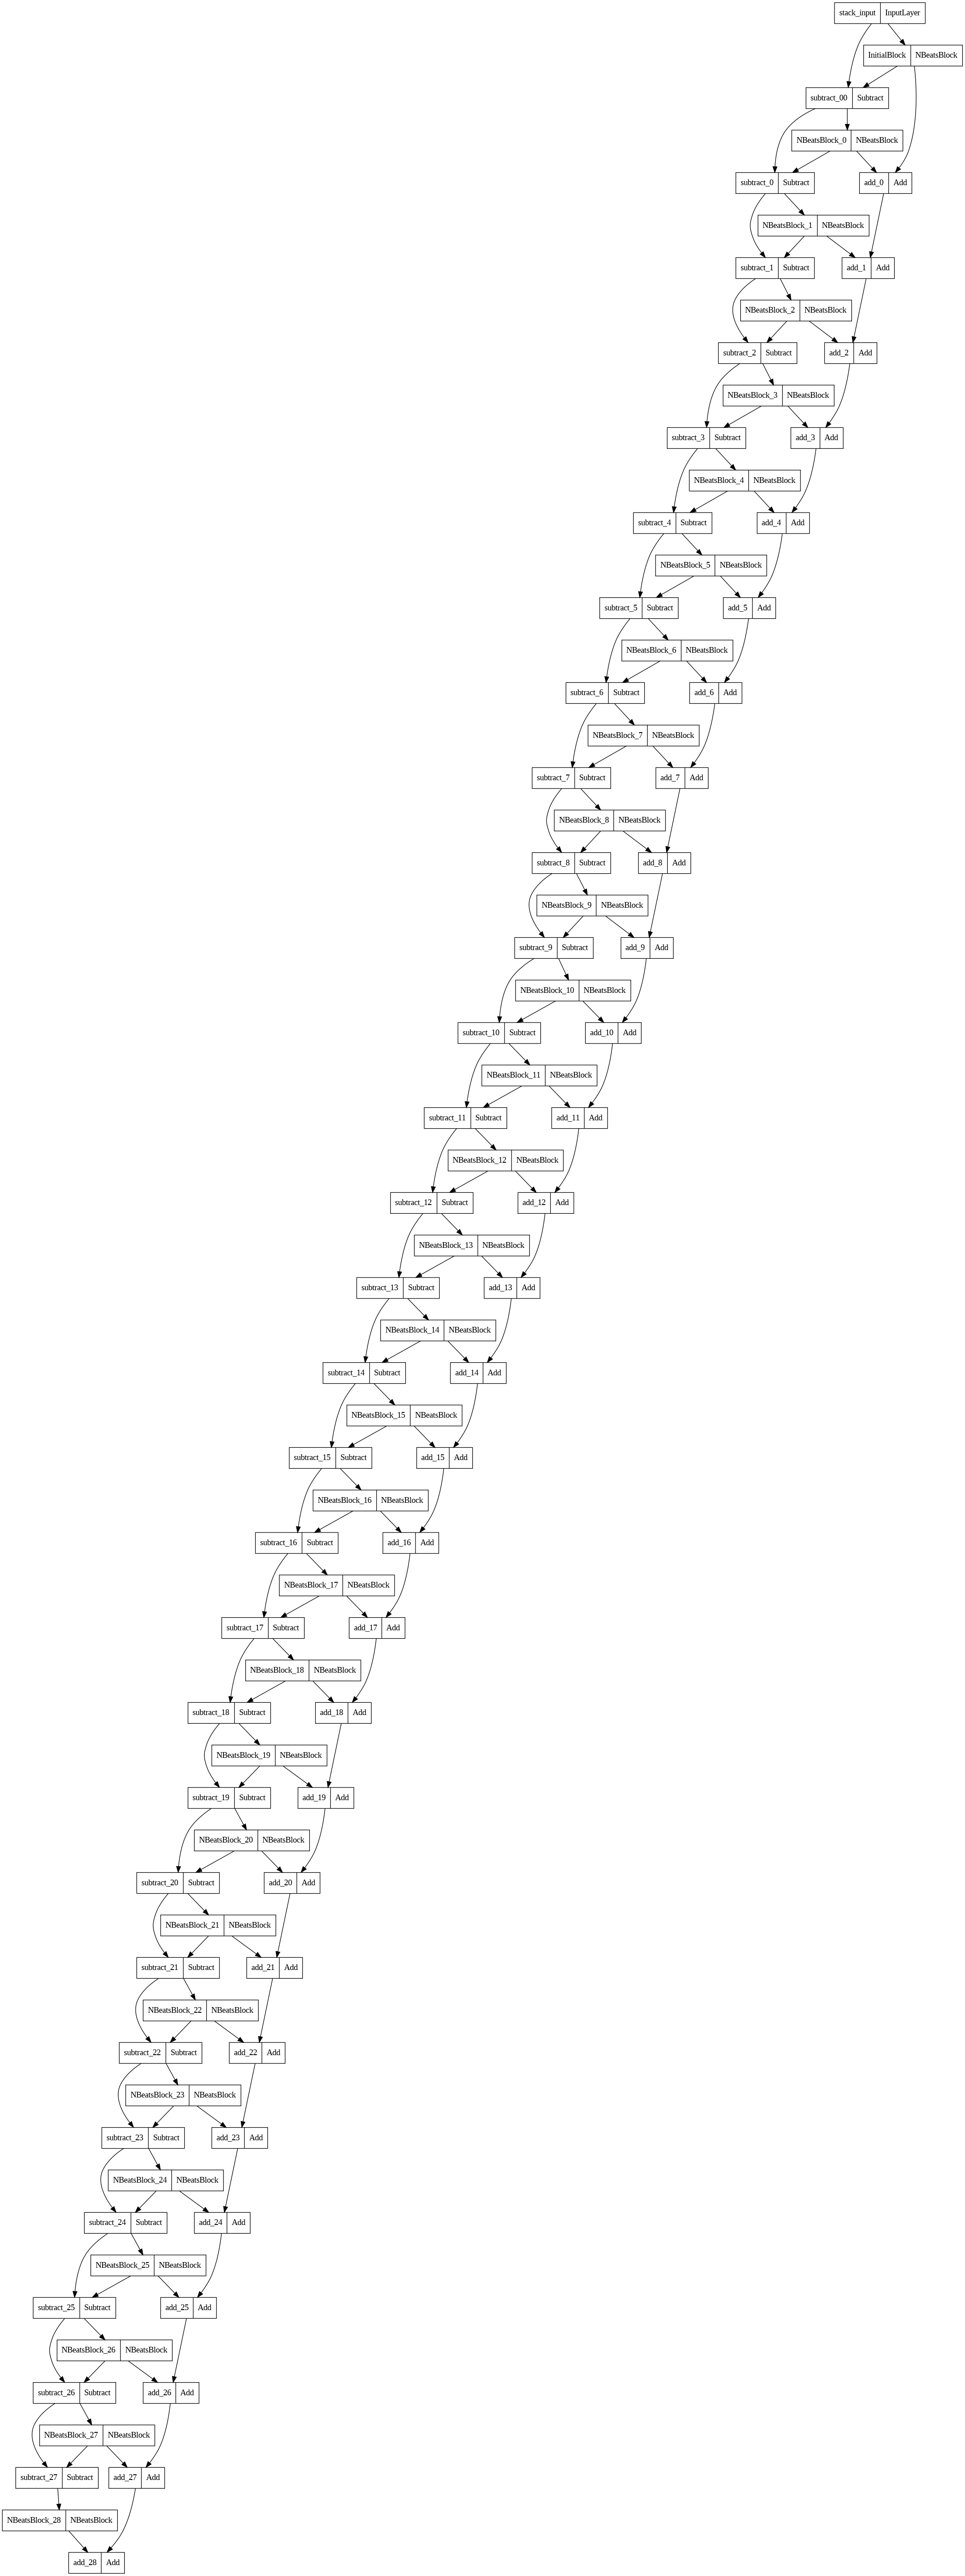

In [109]:
# Plot the N-BEATS model ('model_7')
from tensorflow.keras.utils import plot_model

plot_model(model_7)

## Create, Evaluate and Predict with ‘model_8’ - Ensemble model (stacking different models together - DL model)


Let's first create a function named ‘get_ensemble_models()’ that returns a list of different models trained with different loss functions:

In [110]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of 'num_iter' models where each one of them is trained on the MAE, MSE and MAPE loss functions.
  """
  # Create an empty list for the future trained ensemble models
  ensemble_models = []

  # Creating 'num_iter' number of models per loss function
  for i in range(num_iter):
    # Build, compile and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Build a model with the Sequential API
      model = tf.keras.Sequential([
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Include callback in the model's fitting proccess
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append the built, compiled and fitted model to list of the ensemble models.
      ensemble_models.append(model)

  return ensemble_models

In [111]:
# Let's use the 'get_ensemble_models()' function and get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 855: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 955: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 560: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 660: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 390: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 490: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 789: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 889: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 381: ReduceLROnPl

Let's now create a function which uses the list of trained ensemble models returned by the 'get_ensemble_models()' function to make and return a list of predictions:

In [112]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []

  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)

  return tf.constant(tf.squeeze(ensemble_preds))

In [113]:
# Create a list of the ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 60ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8801.183,  8810.651,  9055.284, ..., 50301.42 , 48283.203,
        46158.32 ],
       [ 8753.393,  8787.991,  9049.983, ..., 50085.047, 47719.992,
        46336.582],
       [ 8823.422,  8799.053,  9009.48 , ..., 49987.074, 48998.695,
        45822.062],
       ...,
       [ 8797.086,  8768.927,  9053.474, ..., 49999.516, 48490.035,
        46696.527],
       [ 8787.507,  8786.012,  8991.142, ..., 50005.18 , 49120.69 ,
        46987.33 ],
       [ 8782.807,  8760.754,  9106.275, ..., 50054.48 , 48416.242,
        45648.254]], dtype=float32)>

In [114]:
# Evaluate the ensemble models predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': 562.79224,
 'mse': 1127334.5,
 'rmse': 1061.7601,
 'mape': 2.544421,
 'mase': 0.98867005}

Let's plot the prediction intervals (uncertainty estimates) of the ensemble model:

In [115]:
# Creating a function for finding out the upper and lower bounds of the ensemble predictions
def get_upper_lower(preds):
  # Calculate the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  interval = 1.96 * std
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  # return the upper and lower bounds
  return lower, upper

In [116]:
# Get the upper and lower bounds
lower, upper = get_upper_lower(preds=ensemble_preds)

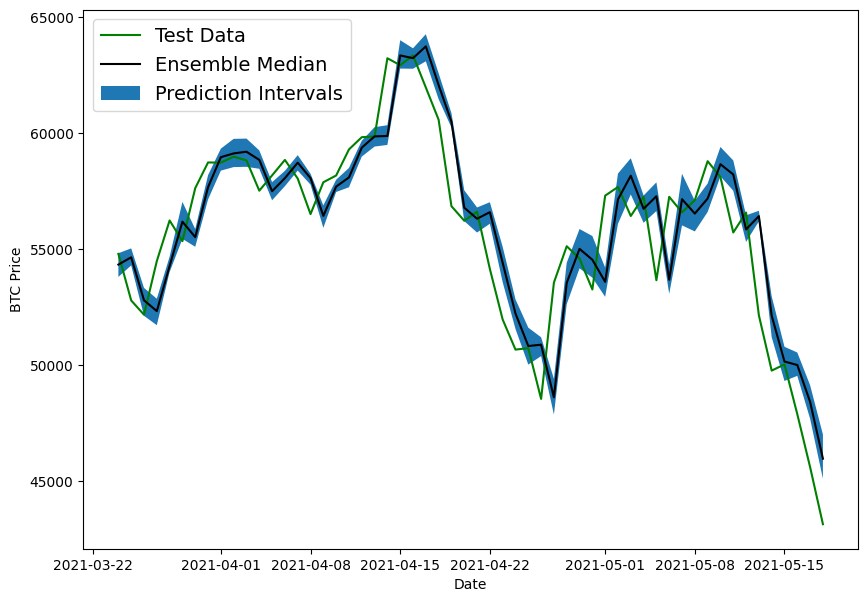

In [117]:
# Get the median values of the ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of the ensemble preds with the prediction intervals
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

## Create, Evaluate and Predict with ‘model_9’ - Train a model on the **full historical dataset** (similar to ‘model_1’ but with an extra Dense layer - DL model)

Since the goal of a forecasting model is to predict values into the actual-future, we will not use a test set. Instead, let's train a **univariate** model on the **full dataset**, and then make predictions to some future horizon:


In [118]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [119]:
# Create X features and y labels on the full dataset
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [120]:
# Transform the X features and y labels into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine the features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [121]:
# Setting the random seed for getting reproducible results
tf.random.set_seed(42)

# # Build, compile and fit 'model_9' with the Keras Sequential API
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

In [122]:
# Set 14 (days) to be the number of timesteps to predict into the future
INTO_FUTURE = 14

In [123]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  The function makes future forecasts 'into_future' steps after values ends.
  Returns future forecasts as list of floats.
  """
  # Create an empty list for future forecasts
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # Make 'INTO_FUTURE' number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # Update the last window with the new pred and get the 'WINDOW_SIZ'E most recent preds
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [124]:
# Let's make forecasts into the future
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 70ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55517.4140625

1/1 [==============================] - 0s 28ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55517.4140625 ] -> Prediction: 49250.4375

1/1 [==============================] - 0s 23ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55517.4140625  49250.4375    ] -> Prediction: 49829.1875

1/1 [==============================] - 0s 24ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55517.4140625  49250.4375     49829.1875    ] -> Prediction: 47577.796875

1/1 [==============================] - 0s 23ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55517.4140625
 49250.4375     49829.1875     47577.796875  ] -> 

In [125]:
future_forecast[:10]

[55517.414,
 49250.438,
 49829.188,
 47577.797,
 48330.74,
 44984.836,
 48543.79,
 52586.28,
 48821.7,
 48532.07]

In [126]:
def get_future_dates(start_date, into_future, offset=1):
  """
  The function returns array of datetime values from ranging from the 'start_date' to 'start_date+horizon'.

  Parameters
  ---------
  start_date: date to start range
  into_future: number of days to add onto start date for range
  offset: number of days to offset 'start_date', by default 1
  """
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")

  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [127]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [128]:
# Let's get the next 2 weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [129]:
# Make sure to insert the last timestep (final price) before plotting it so the graph won't look messed up
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])

next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55517.414, 49250.438, 49829.188, 47577.797, 48330.74 ,
        44984.836, 48543.79 , 52586.28 , 48821.7  , 48532.07 , 47459.03 ,
        47967.37 , 46454.2  , 50219.086], dtype=float32))

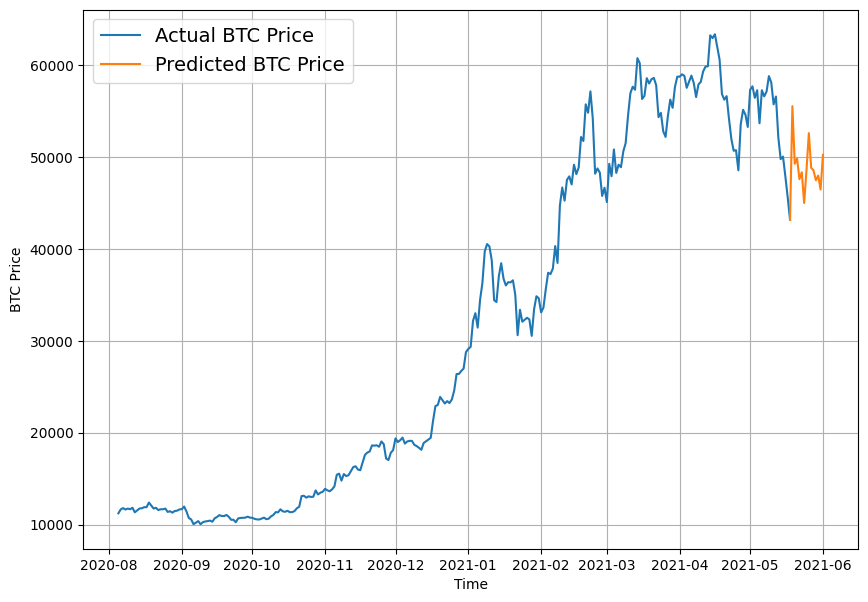

In [130]:
# Plot the future price predictions
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Conclusion


After analyzing the performance of the 9 different machine learning and deep learning models, it is evident that they all perform poorly in predicting the future price of Bitcoin, even over short-term horizons. The predictions tend to exhibit a cyclic pattern with repeated ups and downs, suggesting potential issues with overfitting. Overfitting occurs when a model learns the training data too well, capturing noise and fluctuations instead of the underlying trend, leading to poor generalization on new data.

This project highlights the inherent difficulty in forecasting Bitcoin prices (and any other stock price), emphasizing that it may be impossible to accurately predict the behavior of such highly volatile and speculative assets.
Several factors contribute to this complexity:

**1. Market Volatility:** Bitcoin prices and stocks prices in general are notoriously volatile, influenced by a myriad of factors including market sentiment, regulatory news, macroeconomic trends and technological developments. These rapid and unpredictable changes make it challenging for models to capture consistent patterns.

**2. Market Sentiment:** Cryptocurrencies, including Bitcoin are heavily influenced by investor sentiment which can be erratic and driven by news, social media and speculative behavior. Quantifying and incorporating such sentiment into models is inherently difficult.

**3. Regulatory Environment:** The regulatory landscape for cryptocurrencies is constantly evolving. News of regulatory actions or changes in policy can cause significant price movements, adding another layer of unpredictability.

**4. Technological Factors:** Developments in blockchain technology, adoption rates and innovations in related fields can impact Bitcoin prices. These factors are not easily quantifiable or predictable.

**5. External Events:** Unforeseen events such as economic crises, geopolitical developments, or major financial institution movements can have substantial impacts on Bitcoin prices.

In conclusion, the failure of the models to accurately forecast Bitcoin prices underscores the limitations of using traditional machine learning and deep learning techniques for predicting the behavior of **open systems** like cryptocurrency markets. The high mean squared error values even for short-term predictions, suggest that accurate forecasting may be inherently impossible due to the multitude of dynamic and often unforeseeable factors at play. Moreover, while forecasting models should ideally be retrained with each new data point to improve accuracy, this process was not performed in this project because it was believed that retraining would not significantly alter the final results due to the aforementioned challenges. This phenomenon can also be likened to the "turkey problem", where predictions based solely on historical data fail to account for unexpected, high-impact events. This project demonstrates the challenges and limitations of predicting stock prices in such an unpredictable environment.